# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинговое

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [4]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='darkgrid')
filterwarnings('ignore')

In [5]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [7]:
%load_ext autoreload

In [8]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

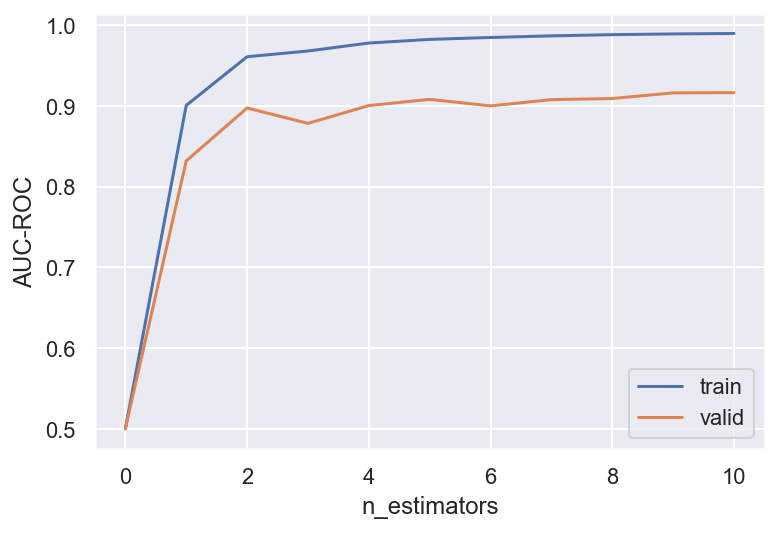

Wall time: 2.06 s
Train ROC-AUC 0.9899
Valid ROC-AUC 0.9165
Test ROC-AUC 0.9162


In [25]:
boosting = Boosting(plot=True)

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

## Задание 2. Обучение градиентного бустинга (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

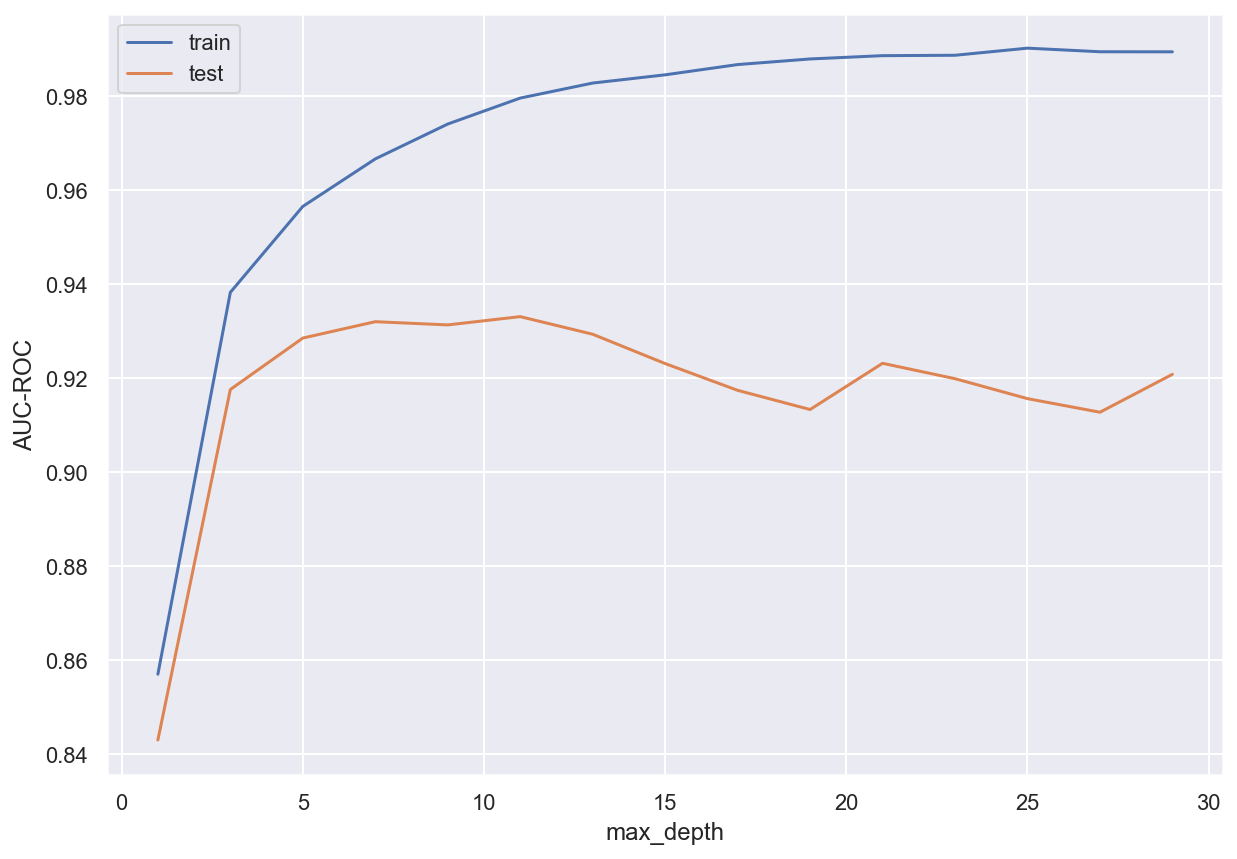

In [27]:
from collections import defaultdict

results = defaultdict(list)
depths = range(1, 30, 2)

for depth in depths:
    boosting = Boosting(base_model_params={'max_depth': depth})
    boosting.fit(x_train, y_train, x_valid, y_valid)
    results['train'].append(boosting.score(x_train, y_train))
    results['test'].append(boosting.score(x_test, y_test))

plt.figure(figsize=(10, 7))
plt.plot(depths, results['train'], label='train')
plt.plot(depths, results['test'], label='test')
plt.xlabel('max_depth')
plt.ylabel('AUC-ROC')
plt.legend()
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

In [29]:
train_best = np.argmax(results['train'])
test_best = np.argmax(results['test'])

print(f'Best train ROC-AUC = {results["train"][train_best]} with max_depth = {depths[train_best]}')
print(f'Best test ROC-AUC = {results["test"][test_best]} with max_depth = {depths[test_best]}')    

Best train ROC-AUC = 0.9901824476909187 with max_depth = 25
Best test ROC-AUC = 0.9330759553661259 with max_depth = 11


Как известно из лекций, градиентный бустинг склонен к переобучению. Если рассуждать в терминах смещения и разброса, бустинг нацелен в первую очередь на минимизацию смещения, в то время как разброс будет сильно зависеть от разброса базового метода обучения. Именно поэтому в качестве базовых моделей рекомендуется брать неглубокие деревья &mdash; они меньше склонны к переобучению. Наш эксперимент это подтвердил: видно, что начиная с некоторого момента, качество на тестовой выборке стало падать, что как раз является следствием использования глубоких деревьев в качестве базовых моделей. А наилучшее качество с $\text{AUC-ROC} \approx 0.93$ на тестовой выборке достигается на `max_depth` $= 11$.

Для менее глубоких деревьев качество получилось хуже, скорее всего, из-за недостаточно большого значения `n_estimators`. Если взять побольше базовых моделей, то вполне возможно, что лучшее качество будет у ещё менее глубокого дерева.

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (2 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей.

Для начала реализуем функцию подбора одного гиперпараметра:

In [24]:
def tune_hyperparameter(
        estimator, param_name, param_range, score,
        x_train, y_train, x_valid, y_valid,
        shape, loc, # for graph
        fixed_params={}, fit_with_valid=False, is_base_model_param=False
):
    results = defaultdict(list)
    args = fixed_params.copy()
    for param in param_range:
        if is_base_model_param:
            args.setdefault('base_model_params', {})
            args['base_model_params'][param_name] = param
        else:
            args[param_name] = param
        model = estimator(**args)
        if fit_with_valid:
            model.fit(x_train, y_train, x_valid, y_valid)
        else:
            model.fit(x_train, y_train)
        results['train'].append(score(model, x_train, y_train))
        results['valid'].append(score(model, x_valid, y_valid))
    
    plt.subplot2grid(shape, loc)
    plt.plot(param_range, results['train'], label='train')
    plt.plot(param_range, results['valid'], label='valid')
    plt.xlabel(param_name)
    plt.ylabel('AUC-ROC')
    plt.legend()
    
    best_param_inedex = np.argmax(results['valid'])
    return param_range[best_param_inedex], results['valid'][best_param_inedex]

Мне кажется разумной стратегия последовательного подбора. Давайте переберём гиперпараметры `n_estimators`, `learning_rate`, `subsample`, `max_depth` и `min_samples_leaf` (именно в таком порядке) по соответствующим сеткам. При этом каждый следующий параметр будем тюнить уже для модели со всеми подобранными предыдущими.

Best n_estimators = 29 with AUC-ROC = 0.9282119005485967 on validation
Best learning_rate = 0.060689655172413794 with AUC-ROC = 0.9268505858322698 on validation
Best subsample = 0.1 with AUC-ROC = 0.9292766873158673 on validation
Best max_depth = 9 with AUC-ROC = 0.9372969102825356 on validation
Best min_samples_leaf = 5 with AUC-ROC = 0.937005570574849 on validation


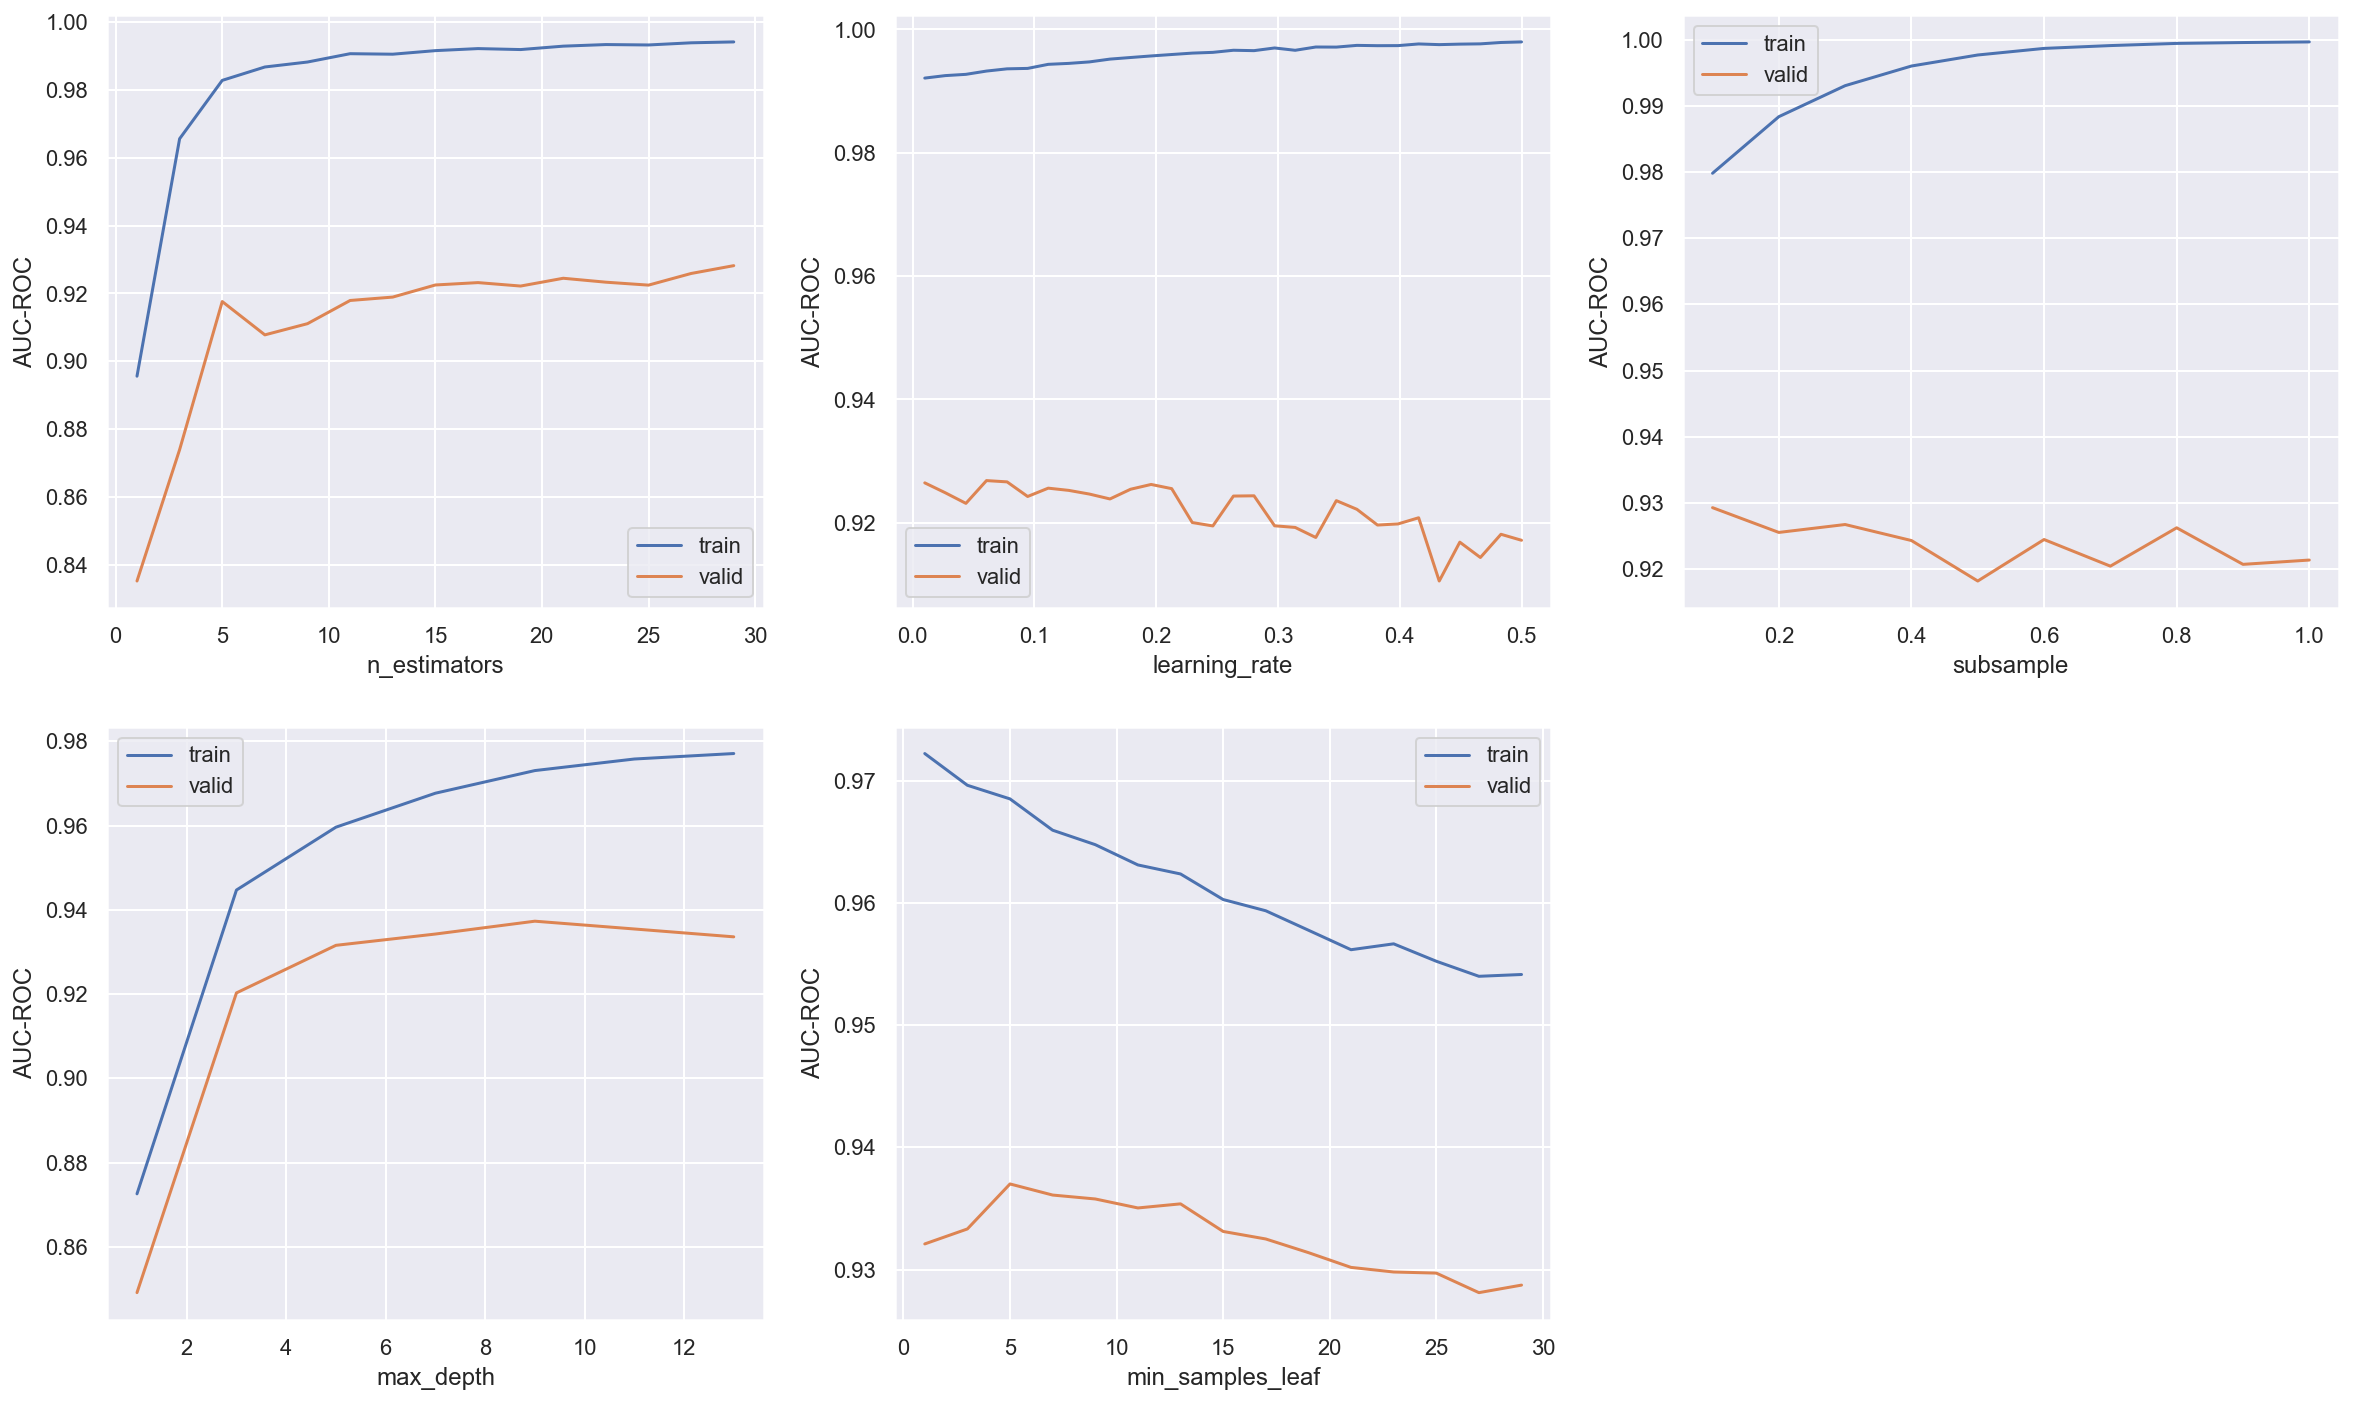

In [30]:
from boosting import score as boosting_score

param_info = [
    ('n_estimators',     np.arange(1, 30, 2),        False),
    ('learning_rate',    np.linspace(0.01, 0.5, 30), False),
    ('subsample',        np.linspace(0.1, 1, 10),    False),
    ('max_depth',        np.arange(1, 15, 2),        True),
    ('min_samples_leaf', np.arange(1, 30, 2),        True)
]
optimal_params = {}

plt.figure(figsize=(20, 12))
for i, (param_name, param_space, is_base_model_param) in enumerate(param_info):
    best_param, best_score = tune_hyperparameter(
        Boosting, param_name, param_space, boosting_score,
        x_train, y_train, x_valid, y_valid,
        (2, 3), (i // 3, i % 3),
        fixed_params=optimal_params, fit_with_valid=True,
        is_base_model_param=is_base_model_param
    )
    if is_base_model_param:
        optimal_params.setdefault('base_model_params', {})
        optimal_params['base_model_params'][param_name] = best_param
    else:
        optimal_params[param_name] = best_param
    print(f'Best {param_name} = {best_param} with AUC-ROC = {best_score} on validation')

In [31]:
optimal_params

{'n_estimators': 29,
 'learning_rate': 0.060689655172413794,
 'subsample': 0.1,
 'base_model_params': {'max_depth': 9, 'min_samples_leaf': 5}}

## Задание 4. Пробуем разные библиотеки (2 балла)

Выберите себе библиотеку с реализацией градиентного бустинга по вкусу из следующих трёх - [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html), [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html), [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart). Подберите основные гиперпараметры, постарайтесь добиться наилучшего качества на тестовых данных. Сравните результаты своей реализации с результатами библиотечного бустинга.

Будем работать с реализацией из библиотеки `CatBoost`. По аналогичному предыдущему заданию принципу подберём гиперпараметры `iterations` ($=$ `n_estimators`), `learning_rate`, `subsample`, `depth` ($=$ `max_depth`) и `min_data_in_leaf` ($=$ `min_samples_leaf`) по тем же сеткам:

Best iterations = 27 with AUC-ROC = 0.9444191683967457 on validation
Best learning_rate = 0.48310344827586205 with AUC-ROC = 0.945946107741415 on validation
Best subsample = 0.8 with AUC-ROC = 0.945946107741415 on validation
Best depth = 5 with AUC-ROC = 0.9458583067336189 on validation
Best min_data_in_leaf = 1 with AUC-ROC = 0.9458583067336189 on validation


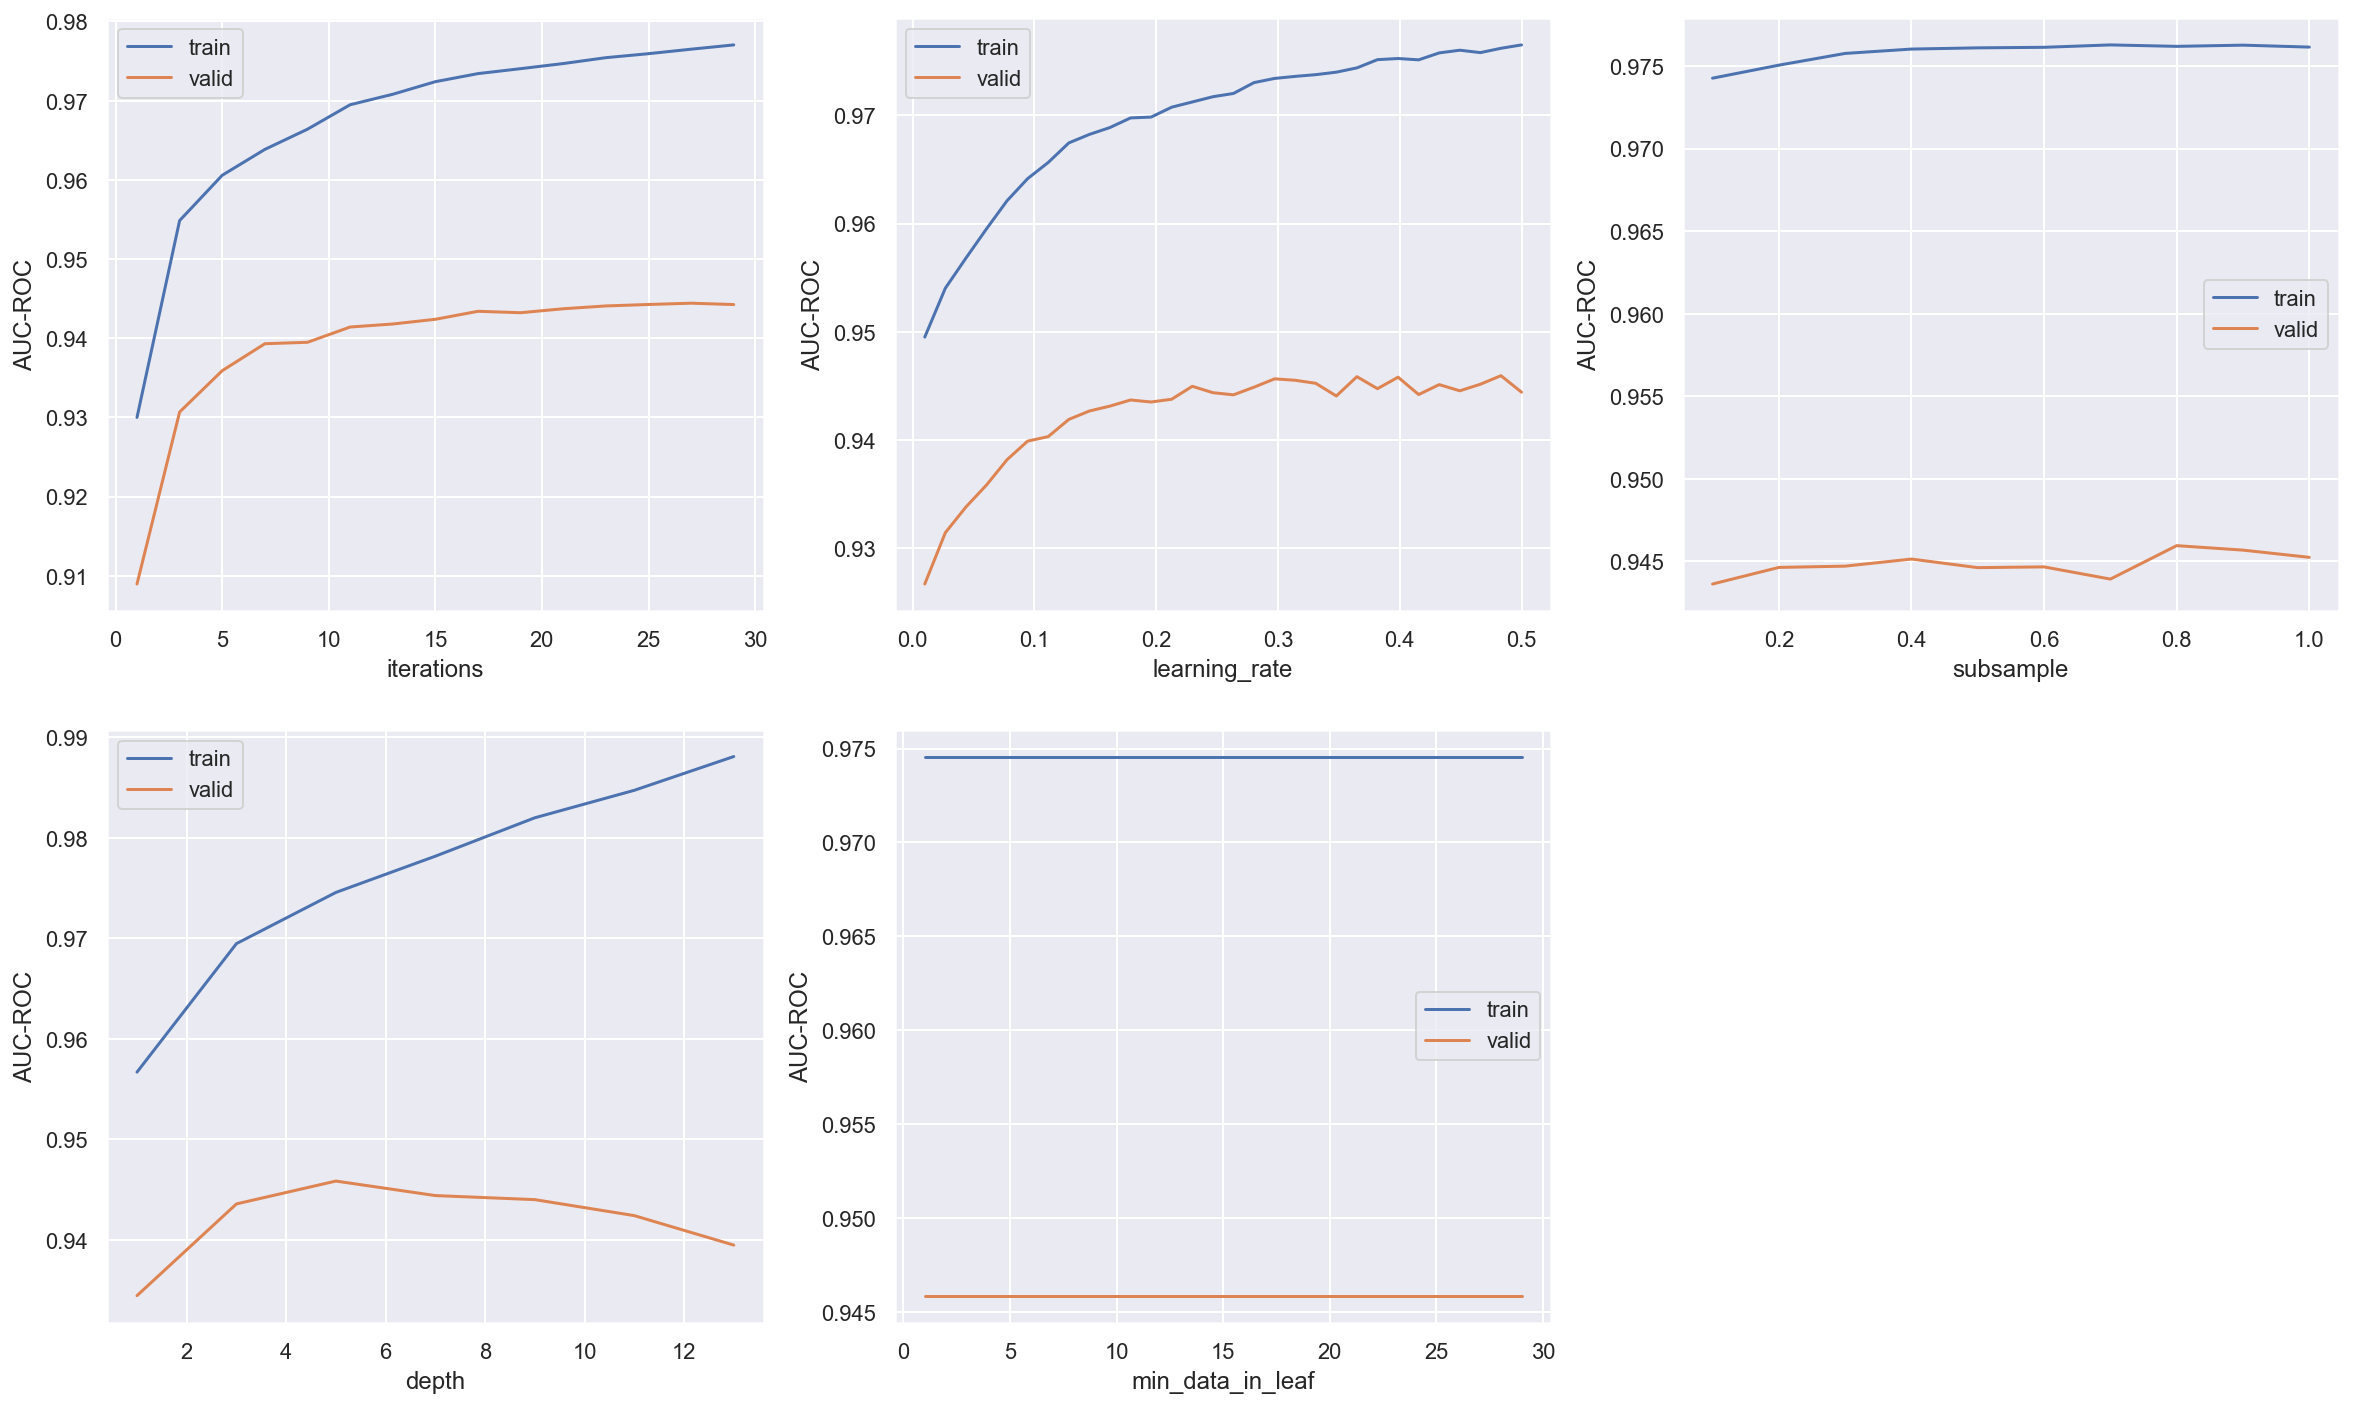

In [29]:
from catboost import CatBoostClassifier

param_info = [
    ('iterations',       np.arange(1, 30, 2)),
    ('learning_rate',    np.linspace(0.01, 0.5, 30)),
    ('subsample',        np.linspace(0.1, 1, 10)),
    ('depth',            np.arange(1, 15, 2)),
    ('min_data_in_leaf', np.arange(1, 30, 2))
]
catboost_optimal_params = {'silent': True}

plt.figure(figsize=(20, 12))
for i, (param_name, param_space) in enumerate(param_info):
    best_param, best_score = tune_hyperparameter(
        CatBoostClassifier, param_name, param_space, boosting_score,
        x_train, y_train, x_valid, y_valid,
        (2, 3), (i // 3, i % 3),
        fixed_params=catboost_optimal_params,
        fit_with_valid=False
    )
    catboost_optimal_params[param_name] = best_param
    print(f'Best {param_name} = {best_param} with AUC-ROC = {best_score} on validation')

In [32]:
catboost_optimal_params

{'silent': True,
 'iterations': 27,
 'learning_rate': 0.48310344827586205,
 'subsample': 0.8,
 'depth': 5,
 'min_data_in_leaf': 1}

Отметим, что оптимальные наборы гиперпараметров для нашей реализации бустинга и для библиотечной немного отличаются. Сравним их:
* Очень маленький `learning_rate` ($\approx 0.06$) получился для нашей модели, тогда как для `CatBoost` он равен $\approx 0.48$. Это может быть связано с более качественной процедурой обучения базовых моделей в библиотечном бустинге &mdash; как известно, чем больше темп обучения, тем больше мы "доверяем" направлению, которое предсказала очередная базовая модель;
* Оптимальные `subsample` тоже сильно отличаются: наша модель показывает наилучшее качество на валидации, обучая базовые модели на $10\%$ данных, в то время как `CatBoost` &mdash; на $80\%$. Получается, что нашей модели важна сильная рандомизация по обучающей выборке;
* А вот оптимальные количества базовых моделей не сильно отличаются &mdash; $29$ и $27$ для нашей реализации и для `CatBoost` соответственно;
* Что касается глубины деревьев и минимального числа объектов в листе, то тут тоже результаты довольно похожи. Однако стоит обратить внимание на то, что библиотечной реализации абсолютно всё равно на `min_data_in_leaf` &mdash; она показывает одинаковое качество для всех значений этого параметра.

Оба алгоритма показали достойное значение метрики качества на валидационной выборке, но всё же у `CatBoost` чуточку лучше. Давайте сравним модели и на тестовых данных:

In [34]:
best_my_boosting = Boosting(**optimal_params)
best_my_boosting.fit(x_train, y_train, x_valid, y_valid)
best_catboost = CatBoostClassifier(**catboost_optimal_params)
best_catboost.fit(x_train, y_train)

print('Boosting:')
print(f'Train ROC-AUC = {boosting_score(best_my_boosting, x_train, y_train):.4f}')
print(f'Valid ROC-AUC = {boosting_score(best_my_boosting, x_valid, y_valid):.4f}')
print(f'Test ROC-AUC = {boosting_score(best_my_boosting, x_test, y_test):.4f}')

print('\nCatBoostClassifier:')
print(f'Train ROC-AUC = {boosting_score(best_catboost, x_train, y_train):.4f}')
print(f'Valid ROC-AUC = {boosting_score(best_catboost, x_valid, y_valid):.4f}')
print(f'Test ROC-AUC = {boosting_score(best_catboost, x_test, y_test):.4f}')

Boosting:
Train ROC-AUC = 0.9676
Valid ROC-AUC = 0.9352
Test ROC-AUC = 0.9332

CatBoostClassifier:
Train ROC-AUC = 0.9746
Valid ROC-AUC = 0.9459
Test ROC-AUC = 0.9392


Итак, библиотечная реализации бустинга превосходит нашу на всех выборках, однако на тестовой разница измеряется тысячными, поэтому можно сказать, что обобщающая способность получилась примерно одинаковой.

### Задание 5 (бонус). Пробуем ещё немножко библиотек (1 балл)

Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/). Сравните полученное качество с вашим ручным перебором. Используйте эту библиотеку чтобы подобрать параметры и для своей реалзиации и для библиотечной.

## Задание 6. Интерпретация бустингового (1 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга (из тех, что используют вашу реализацию).
Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регресии, сравните их между собой. Проанализируйте полученные результаты.

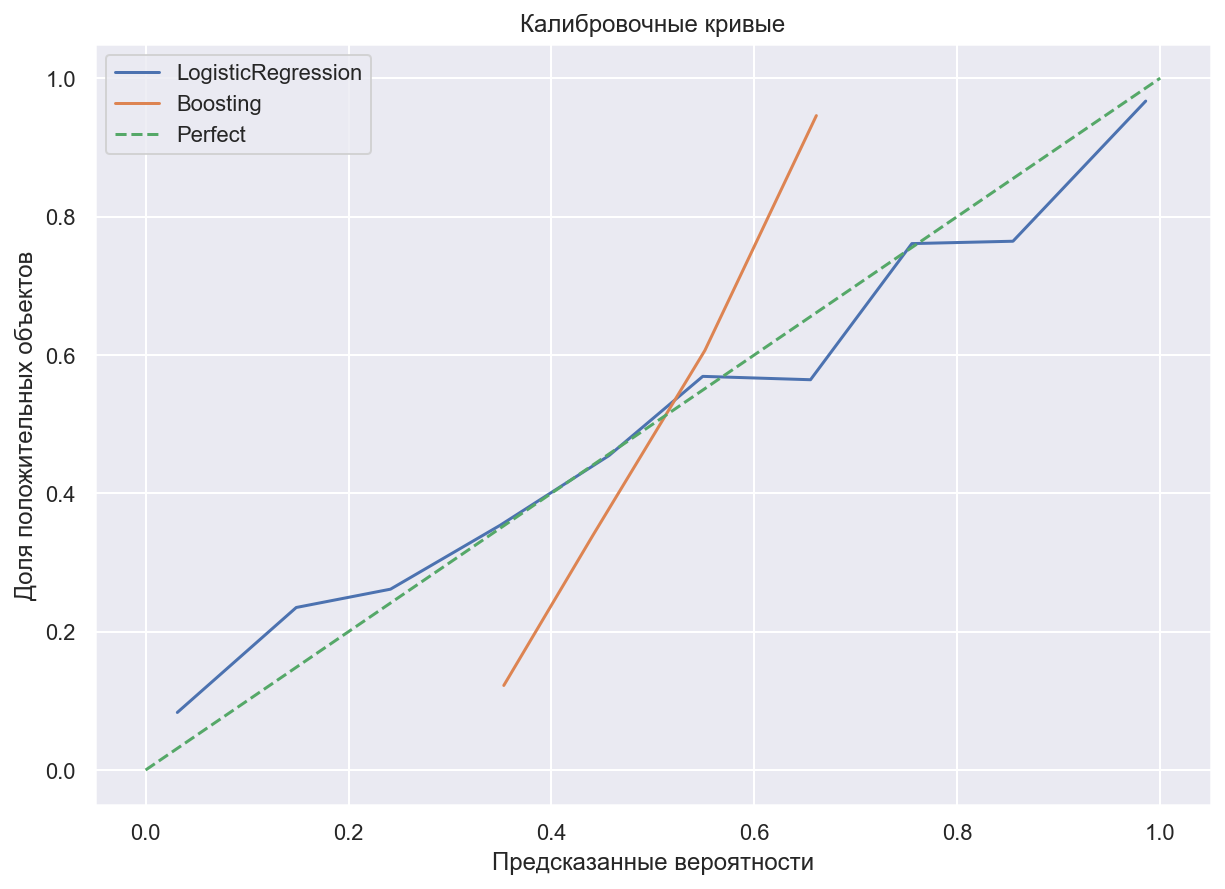

In [42]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

boosting_pred = best_my_boosting.predict_proba(x_test)[:, 1]
lr = LogisticRegression().fit(x_train, y_train)
lr_pred = lr.predict_proba(x_test)[:, 1]

lr_prob_true, lr_prob_pred = calibration_curve(y_test, lr_pred, n_bins=10)
boosting_prob_true, boosting_prob_pred = calibration_curve(y_test, boosting_pred, n_bins=10)

plt.figure(figsize=(10, 7))
plt.plot(lr_prob_pred, lr_prob_true, label='LogisticRegression')
plt.plot(boosting_prob_pred, boosting_prob_true, label='Boosting')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--')
plt.title('Калибровочные кривые')
plt.xlabel('Предсказанные вероятности')
plt.ylabel('Доля положительных объектов')
plt.legend()
plt.show()

Судя по кривой для бустинга, предсказывать вероятности у него, мягко говоря, не очень получается, поскольку расхождение с зелёной кривой уж слишком велико. Но мы и не требовали это от него при построении, так что такой результат кажется вполне логичным. А вот логистическая регрессия, как тоже видно из графика, оценивает вероятности сравнительно неплохо &mdash; соответствующая кривая в среднем не сильно отстоит от зелёной кривой. И это тоже логичный результат, ведь, как известно из лекций, логистическая регрессия удовлетворяет условию корректного оценивания вероятностей.

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

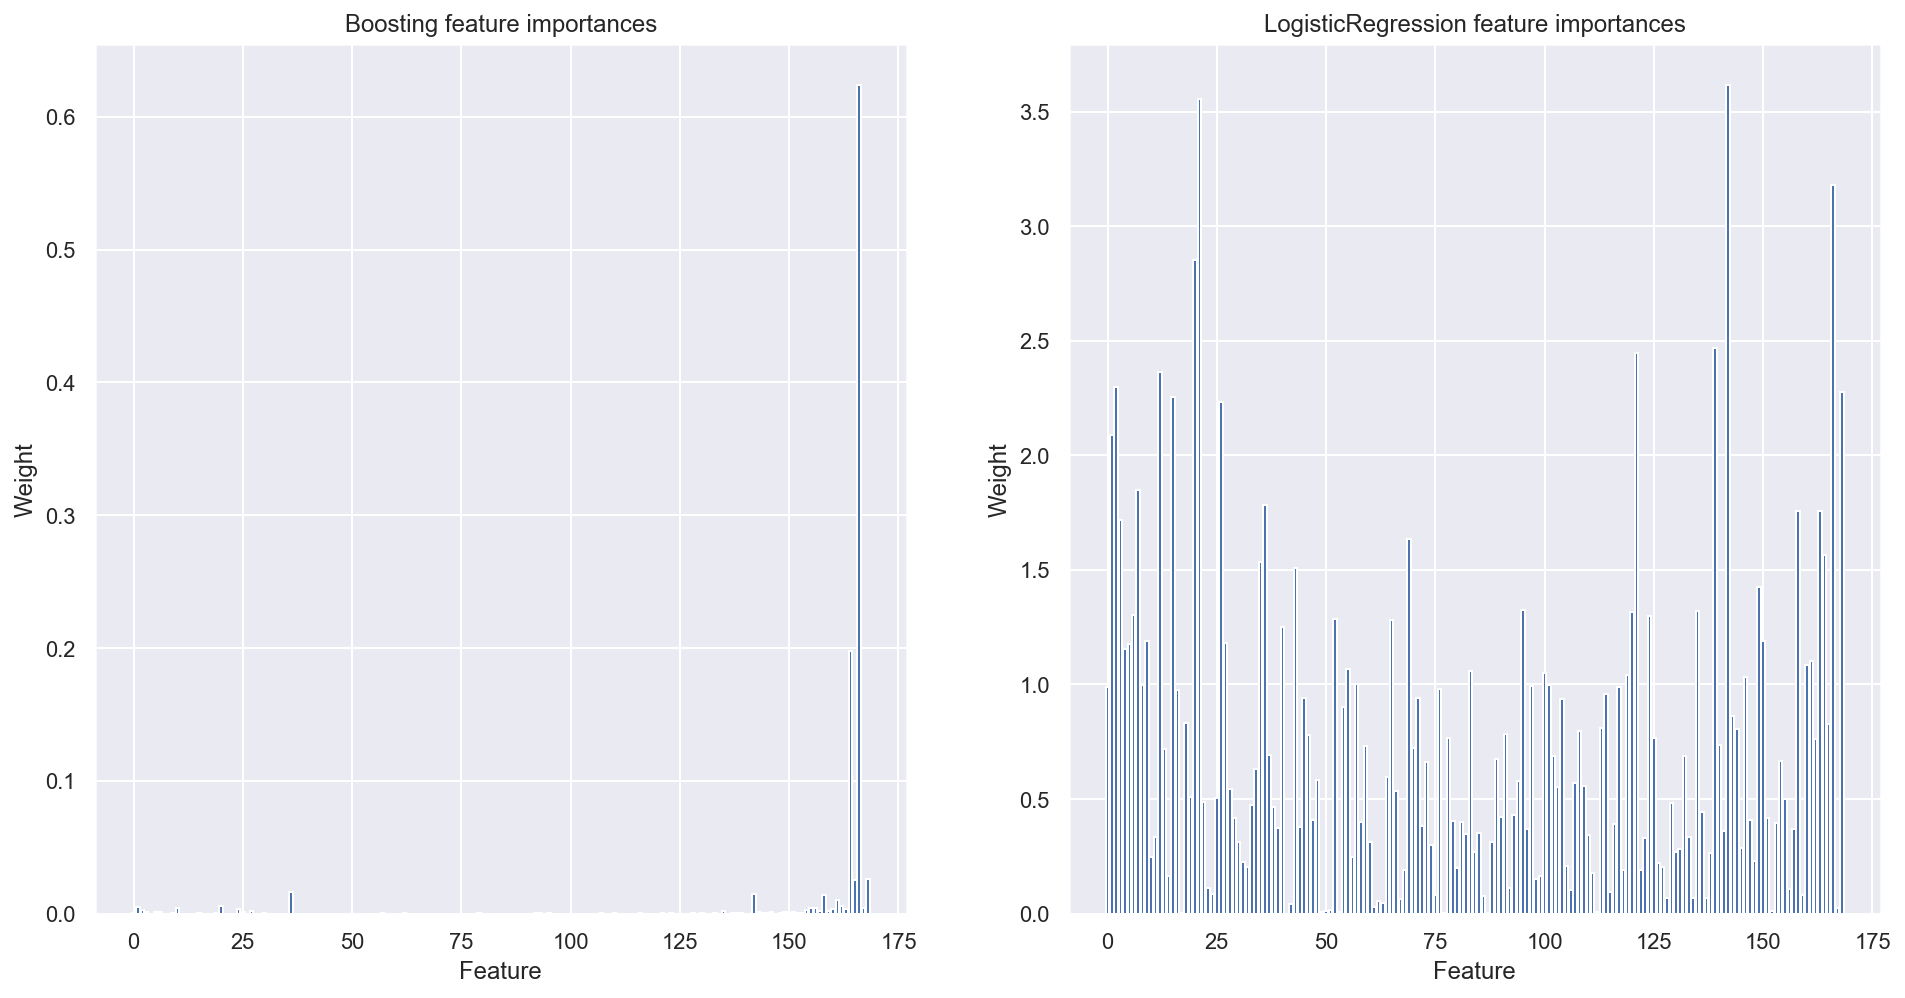

In [61]:
plt.figure(figsize=(16, 8))

plt.subplot2grid((1, 2), (0, 0))
plt.bar(np.arange(x.shape[1]), best_my_boosting.feature_importances_)
plt.title('Boosting feature importances')
plt.xlabel('Feature')
plt.ylabel('Weight')

plt.subplot2grid((1, 2), (0, 1))
plt.bar(np.arange(x.shape[1]), np.abs(lr.coef_[0]))
plt.title('LogisticRegression feature importances')
plt.xlabel('Feature')
plt.ylabel('Weight')

plt.show()

Как видно из графиков, для градиентного бустинга важна лишь малая доля признаков, тогда как логистическая регрессия использует гораздо большее их число для вклада в предсказание. Ещё в случае с бустингом один признак прям выделяется на фоне других, в то время как для лог. регрессии у многих признаков вес одинаково большой или средний.

Получается, что бустинг нашёл "золотые" признаки и извлекает закономерности из данных только с помощью них, а лог. регрессия старается использовать всю доступную информацию.

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [82]:
boosting_weights = best_my_boosting.feature_importances_
importance_mask = boosting_weights >= np.quantile(boosting_weights, 0.9)

new_best_boosting = Boosting(**optimal_params)
new_best_boosting.fit(x_train[:, importance_mask], y_train,
                      x_valid[:, importance_mask], y_valid)

print(f'Train ROC-AUC = {new_best_boosting.score(x_train[:, importance_mask], y_train):.4f}')
print(f'Valid ROC-AUC = {new_best_boosting.score(x_valid[:, importance_mask], y_valid):.4f}')
print(f'Test ROC-AUC = {new_best_boosting.score(x_test[:, importance_mask], y_test):.4f}')

Train ROC-AUC = 0.9667
Valid ROC-AUC = 0.9350
Test ROC-AUC = 0.9343


По сравнению с предыдущим результатом, разницы практически никакой (разве только на тесте на пару тысячных выросло качество, но это можно считать влиянием фактора случайности). Немудрено: отфильтрованные признаки и так не вносили вклада в оптимизацию лосса (за это мы их и отфильтровали, собственно) $\implies$ что они есть, что их нет &mdash; результат один :)

## Задание 7 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашими лучшими моделями (ваша реализация с лучшими гиперпараметрами + все модели из библиотек с лучшими гиперпараметрами). Улучшилось ли качество?

Сделаем стекинг логрега с катбустом:

In [92]:
estimators = [
    ('LogisticRegression', LogisticRegression()),
    ('CatBoost', CatBoostClassifier(**catboost_optimal_params))
]
blending_model = StackingClassifier(estimators)
blending_model.fit(x_train, y_train)

print(f'Train ROC-AUC = {boosting_score(blending_model, x_train, y_train):.4f}')
print(f'Valid ROC-AUC = {boosting_score(blending_model, x_valid, y_valid):.4f}')
print(f'Test ROC-AUC = {boosting_score(blending_model, x_test, y_test):.4f}')

Train ROC-AUC = 0.9748
Valid ROC-AUC = 0.9464
Test ROC-AUC = 0.9408


Результат действительно (хоть и совсем не намного) превосходит `CatBoostClassifier`.